<a href="https://colab.research.google.com/github/MohsenMaaleki/CIFAR_10_Objects_Classification/blob/main/CIFAR_10_Objects_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim



import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



torch.manual_seed(0)

In [ ]:
# Load the pre-trained ResNet18 model
model_0 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_0.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_0.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.fc.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_sizes = [32, 64, 128, 256]
loss_values = {batch_size: [] for batch_size in batch_sizes}  # Store the loss values for each batch size


for batch_size in batch_sizes:
    # Create a dataloader with the desired batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Train the model on the CIFAR-10 dataset for 30 epochs
    for epoch in range(20):  # Loop through 10 epochs

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):  # Loop through the data in the training set
            inputs, labels = data  # Get the inputs and labels from the data

            optimizer.zero_grad()  # Zero the gradient buffers

            outputs = model_0(inputs)  # Get the model outputs
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Perform backpropagation
            optimizer.step()  # Update the parameters of the model

            running_loss += loss.item()  # Add up the loss for each iteration

        avg_loss = running_loss / len(trainloader)  # Calculate the average loss for each epoch
        loss_values[batch_size].append(avg_loss)  # Store the average loss value for this epoch and batch size
        print('[Batch size: %d, Epoch %d] loss: %.3f' % (batch_size, epoch + 1, avg_loss))  # Print the average loss for each epoch


[Batch size: 32, Epoch 1] loss: 1.863
[Batch size: 32, Epoch 2] loss: 1.729
[Batch size: 32, Epoch 3] loss: 1.699
[Batch size: 32, Epoch 4] loss: 1.677
[Batch size: 32, Epoch 5] loss: 1.659
[Batch size: 32, Epoch 6] loss: 1.644
[Batch size: 32, Epoch 7] loss: 1.644
[Batch size: 32, Epoch 8] loss: 1.626
[Batch size: 32, Epoch 9] loss: 1.614
[Batch size: 32, Epoch 10] loss: 1.614
[Batch size: 32, Epoch 11] loss: 1.606
[Batch size: 32, Epoch 12] loss: 1.598
[Batch size: 32, Epoch 13] loss: 1.597
[Batch size: 32, Epoch 14] loss: 1.587
[Batch size: 32, Epoch 15] loss: 1.590
[Batch size: 32, Epoch 16] loss: 1.579
[Batch size: 32, Epoch 17] loss: 1.585
[Batch size: 32, Epoch 18] loss: 1.577
[Batch size: 32, Epoch 19] loss: 1.564
[Batch size: 32, Epoch 20] loss: 1.569
[Batch size: 64, Epoch 1] loss: 1.524
[Batch size: 64, Epoch 2] loss: 1.515
[Batch size: 64, Epoch 3] loss: 1.514
[Batch size: 64, Epoch 4] loss: 1.514
[Batch size: 64, Epoch 5] loss: 1.512
[Batch size: 64, Epoch 6] loss: 1.506
[

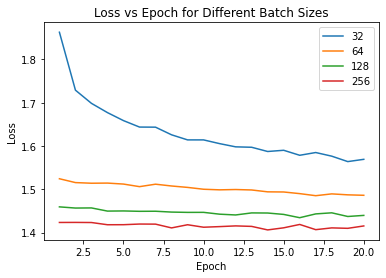

In [ ]:
# Plot the loss values for each batch size and epoch
for batch_size, values in loss_values.items():
    plt.plot(range(1, 21), values, label=str(batch_size))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Batch Sizes')
plt.legend()
plt.show()




In [ ]:
accuracies = []
for batch_size in batch_sizes:
    # Evaluate the model on the CIFAR-10 test set for a specific batch size
    correct = 0  # Keep track of the number of correctly classified samples
    total = 0  # Keep track of the total number of samples evaluated
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    with torch.no_grad():  # Don't keep track of gradients during evaluation
        for data in testloader:
            images, labels = data
            outputs = model_0(images)  # Get the model outputs for a batch of test data
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest predicted probability
            total += labels.size(0)  # Increment the number of samples evaluated
            correct += (predicted == labels).sum().item()  # Increment the number of correctly classified samples

    accuracy = 100 * correct / total  # Calculate the accuracy
    print('[Batch size: %d] Accuracy of the network on the 10000 test images: %.2f %%' % (batch_size, accuracy))  # Print the accuracy for the current batch size
    accuracies.append(accuracy)


[Batch size: 32] Accuracy of the network on the 10000 test images: 45.87 %
[Batch size: 64] Accuracy of the network on the 10000 test images: 47.19 %
[Batch size: 128] Accuracy of the network on the 10000 test images: 47.76 %
[Batch size: 256] Accuracy of the network on the 10000 test images: 48.52 %


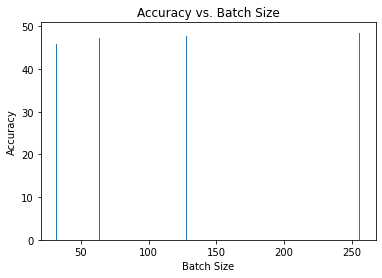

In [ ]:
plt.bar(batch_sizes, accuracies)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size')
plt.show()

#Different Hyperparameters :
  1-Learning rate: 0.01, Batch size: 64, Optimizer: SGD, Epochs: 10, Activation function: ReLU

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 1.9206
Epoch [2/10], Loss: 1.7405
Epoch [3/10], Loss: 1.6958
Epoch [4/10], Loss: 1.6801
Epoch [5/10], Loss: 1.6653
Epoch [6/10], Loss: 1.6541
Epoch [7/10], Loss: 1.6481
Epoch [8/10], Loss: 1.6356
Epoch [9/10], Loss: 1.6227
Epoch [10/10], Loss: 1.6182
Finished Training
Accuracy of the network on the test set: 41.48%
F1 score: 0.41


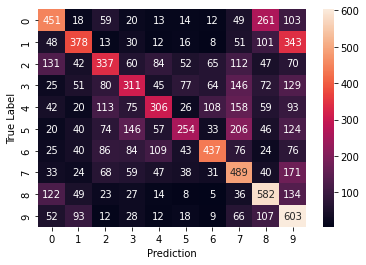

In [ ]:
# Load the pre-trained ResNet18 model
model_1 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_1.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_1.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.SGD(model_1.parameters(), lr=0.01)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)




acc1 = []
epochs1 = 0

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_1(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/10], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))
    epochs1 = epoch + 1



print('Finished Training')


# Evaluate the model on the test set
  
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for data, target in testloader:
        output = model_1(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_predictions.extend(predicted.tolist())
        all_targets.extend(target.tolist())

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))
    acc1.append(accuracy)
    
    # Calculate the confusion matrix
    cm1 = confusion_matrix(all_targets, all_predictions)
    #print('Confusion matrix:')
    #print(cm)
    f1_1 = f1_score(all_targets, all_predictions, average='weighted')
    print('F1 score: {:.2f}'.format(f1_1))


sns.heatmap(cm1, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

# Different Hyperparameters : 
2-Learning rate: 0.1, Batch size: 128, Optimizer: Adam, Epochs: 20, Activation function: Tanh

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 20.3548
Epoch [2/20], Loss: 13.5386
Epoch [3/20], Loss: 11.9335
Epoch [4/20], Loss: 12.4101
Epoch [5/20], Loss: 13.5127
Epoch [6/20], Loss: 11.1949
Epoch [7/20], Loss: 10.9234
Epoch [8/20], Loss: 10.3746
Epoch [9/20], Loss: 10.6705
Epoch [10/20], Loss: 12.9646
Epoch [11/20], Loss: 11.7552
Epoch [12/20], Loss: 11.4191
Epoch [13/20], Loss: 11.5817
Epoch [14/20], Loss: 10.9085
Epoch [15/20], Loss: 11.3278
Epoch [16/20], Loss: 10.8425
Epoch [17/20], Loss: 10.9948
Epoch [18/20], Loss: 11.0029
Epoch [19/20], Loss: 11.2520
Epoch [20/20], Loss: 10.8795
Finished Training
Accuracy of the network on the test set: 20.05%
F1 score: 0.14


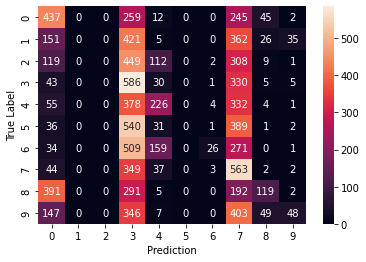

In [ ]:
# Load the pre-trained ResNet18 model
model_2 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_2.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_2.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.Tanh(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adam(model_2.parameters(), lr=0.1)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


acc2 = []
epochs2 = 0


# Train the model
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/20], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))
   
    epochs2 = epoch + 1



print('Finished Training')

# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for data, target in testloader:
        output = model_2(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_predictions.extend(predicted.tolist())
        all_targets.extend(target.tolist())
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))
    acc2.append(accuracy)
    # Calculate the confusion matrix
    cm2 = confusion_matrix(all_targets, all_predictions)
    f1_2 = f1_score(all_targets, all_predictions, average='weighted')
    print('F1 score: {:.2f}'.format(f1_2))

sns.heatmap(cm2, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

#Different Hyperparameters:
3-Learning rate: 0.001, Batch size: 256, Optimizer: Adagrad, Epochs: 30, Activation function: Sigmoid

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Loss: 2.0162
Epoch [2/30], Loss: 1.8592
Epoch [3/30], Loss: 1.8041
Epoch [4/30], Loss: 1.7740
Epoch [5/30], Loss: 1.7532
Epoch [6/30], Loss: 1.7378
Epoch [7/30], Loss: 1.7292
Epoch [8/30], Loss: 1.7183
Epoch [9/30], Loss: 1.7104
Epoch [10/30], Loss: 1.7038
Epoch [11/30], Loss: 1.7003
Epoch [12/30], Loss: 1.6955
Epoch [13/30], Loss: 1.6934
Epoch [14/30], Loss: 1.6871
Epoch [15/30], Loss: 1.6848
Epoch [16/30], Loss: 1.6822
Epoch [17/30], Loss: 1.6785
Epoch [18/30], Loss: 1.6811
Epoch [19/30], Loss: 1.6735
Epoch [20/30], Loss: 1.6746
Epoch [21/30], Loss: 1.6730
Epoch [22/30], Loss: 1.6655
Epoch [23/30], Loss: 1.6656
Epoch [24/30], Loss: 1.6685
Epoch [25/30], Loss: 1.6631
Epoch [26/30], Loss: 1.6602
Epoch [27/30], Loss: 1.6577
Epoch [28/30], Loss: 1.6669
Epoch [29/30], Loss: 1.6540
Epoch [30/30], Loss: 1.6591
Finished Training
Accuracy of the network on the test set: 41.03%
F1 score: 0.41


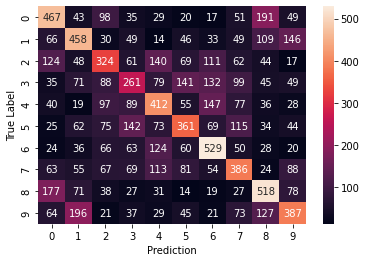

In [ ]:
# Load the pre-trained ResNet18 model
model_3 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_3.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_3.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.Sigmoid(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adagrad(model_3.parameters(), lr=0.001)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)



acc3 = []
epochs3 = 0

# Train the model
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_3(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/30], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))
   
    epochs3 = epoch + 1


print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for data, target in testloader:
        output = model_3(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_predictions.extend(predicted.tolist())
        all_targets.extend(target.tolist())
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))
    acc3.append(accuracy)
    # Calculate the confusion matrix
    cm3 = confusion_matrix(all_targets, all_predictions)
    f1_3 = f1_score(all_targets, all_predictions, average='weighted')
    print('F1 score: {:.2f}'.format(f1_3))

sns.heatmap(cm3, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

#Different Hyperparameters : 
4-Learning rate: 0.05, Batch size: 512, Optimizer: RProp, Epochs: 40, Activation function: Leaky ReLU


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/40], Loss: 129.4159
Epoch [2/40], Loss: 31.5146
Epoch [3/40], Loss: 26.0188
Epoch [4/40], Loss: 24.6438
Epoch [5/40], Loss: 24.0299
Epoch [6/40], Loss: 23.5862
Epoch [7/40], Loss: 23.1906
Epoch [8/40], Loss: 22.8218
Epoch [9/40], Loss: 22.5553
Epoch [10/40], Loss: 22.4102
Epoch [11/40], Loss: 22.4126
Epoch [12/40], Loss: 22.1103
Epoch [13/40], Loss: 21.9885
Epoch [14/40], Loss: 21.9913
Epoch [15/40], Loss: 21.7469
Epoch [16/40], Loss: 21.9079
Epoch [17/40], Loss: 21.7366
Epoch [18/40], Loss: 21.4826
Epoch [19/40], Loss: 21.4153
Epoch [20/40], Loss: 21.3086
Epoch [21/40], Loss: 21.3660
Epoch [22/40], Loss: 21.2401
Epoch [23/40], Loss: 21.1477
Epoch [24/40], Loss: 20.9520
Epoch [25/40], Loss: 20.9176
Epoch [26/40], Loss: 20.6309
Epoch [27/40], Loss: 20.6588
Epoch [28/40], Loss: 20.6521
Epoch [29/40], Loss: 20.4568
Epoch [30/40], Loss: 20.4044
Epoch [31/40], Loss: 20.2449
Epoch [32/40], Loss: 20.2323
Epoc

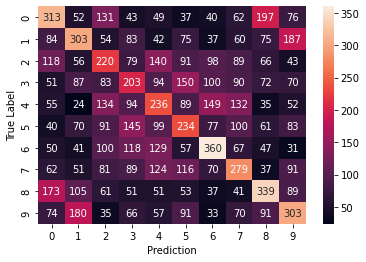

In [ ]:
# Load the pre-trained ResNet18 model
model_4 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_4.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_4.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.05
optimizer = optim.Rprop(model_4.parameters(), lr=0.05)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)


acc4 = []
epochs4 = 0


# Train the model
for epoch in range(40):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_4(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/40], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))
    epochs4 = epoch + 1



print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for data, target in testloader:
        output = model_4(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_predictions.extend(predicted.tolist())
        all_targets.extend(target.tolist())
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))
    acc4.append(accuracy)
    # Calculate the confusion matrix
    cm4 = confusion_matrix(all_targets, all_predictions)

    f1_4 = f1_score(all_targets, all_predictions, average='weighted')
    print('F1 score: {:.2f}'.format(f1_4))


sns.heatmap(cm4, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()


#Different Hyperparameteers:
5-Learning rate: 0.005, Batch size: 128, Optimizer: Adamax, Epochs: 50, Activation function: ELU

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Loss: 1.7917
Epoch [2/50], Loss: 1.6734
Epoch [3/50], Loss: 1.6501
Epoch [4/50], Loss: 1.6319
Epoch [5/50], Loss: 1.6163
Epoch [6/50], Loss: 1.6024
Epoch [7/50], Loss: 1.5889
Epoch [8/50], Loss: 1.5775
Epoch [9/50], Loss: 1.5719
Epoch [10/50], Loss: 1.5656
Epoch [11/50], Loss: 1.5680
Epoch [12/50], Loss: 1.5597
Epoch [13/50], Loss: 1.5523
Epoch [14/50], Loss: 1.5490
Epoch [15/50], Loss: 1.5439
Epoch [16/50], Loss: 1.5349
Epoch [17/50], Loss: 1.5327
Epoch [18/50], Loss: 1.5340
Epoch [19/50], Loss: 1.5329
Epoch [20/50], Loss: 1.5217
Epoch [21/50], Loss: 1.5276
Epoch [22/50], Loss: 1.5140
Epoch [23/50], Loss: 1.5150
Epoch [24/50], Loss: 1.5158
Epoch [25/50], Loss: 1.5039
Epoch [26/50], Loss: 1.5096
Epoch [27/50], Loss: 1.5051
Epoch [28/50], Loss: 1.5004
Epoch [29/50], Loss: 1.5052
Epoch [30/50], Loss: 1.5066
Epoch [31/50], Loss: 1.5101
Epoch [32/50], Loss: 1.5059
Epoch [33/50], Loss: 1.4930
Epoch [34

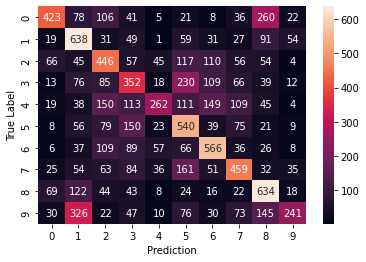

In [ ]:
# Load the pre-trained ResNet18 model
model_5 = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model_5.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model_5.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ELU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adamax(model_5.parameters(), lr=0.005)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



acc5 = []
epochs5 = 0

# Train the model
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_5(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/50], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))
    epochs5 = epoch + 1


print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for data, target in testloader:
        output = model_5(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_predictions.extend(predicted.tolist())
        all_targets.extend(target.tolist())
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))
    acc5.append(accuracy)
    # Calculate the confusion matrix
    cm5 = confusion_matrix(all_targets, all_predictions)
    f1_5 = f1_score(all_targets, all_predictions, average='weighted')
    print('F1 score: {:.2f}'.format(f1_5))

sns.heatmap(cm5, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()


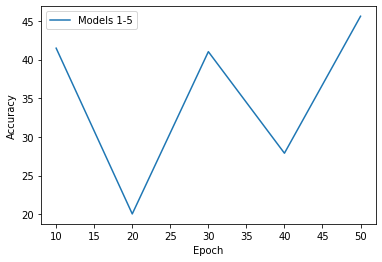

In [ ]:
# Plot the accuracy
epochs = [10, 20, 30, 40, 50]
# acc1=42.48
# acc2=20.05
# acc3=41.3
# acc4=27.90
# acc5=45.73
plt.plot(epochs, [acc1, acc2, acc3, acc4, acc5], label='Models 1-5')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Create a figure with 5 subplots
fig, ax = plt.subplots(1, 5)

# Plot the first confusion matrix in the first subplot
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens', ax=ax[0])

# Plot the second confusion matrix in the second subplot
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[1])

# Plot the third confusion matrix in the third subplot
sns.heatmap(cm3, annot=True, fmt='d', cmap='Reds', ax=ax[2])

# Plot the fourth confusion matrix in the fourth subplot
sns.heatmap(cm4, annot=True, fmt='d', cmap='Purples', ax=ax[3])

# Plot the fifth confusion matrix in the fifth subplot
sns.heatmap(cm5, annot=True, fmt='d', cmap='Accent', ax=ax[4])

# Display the figure
plt.show()


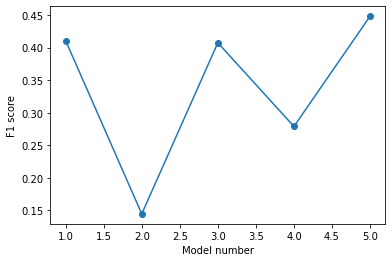

In [ ]:
# Plot the F1 score of each model
# f1_1 =0.42
# f1_2 =0.11 
# f1_3 =0.41
# f1_4 =0.29 
#f1_5 =0.45 
plt.plot([1, 2, 3, 4, 5], [f1_1, f1_2, f1_3, f1_4, f1_5], marker='o')

# Add labels and legend
plt.xlabel('Model number')
plt.ylabel('F1 score')

# Show the plot
plt.show()

Model 1: The image is predicted to be a truck with 17.92% confidence
Model 2: The image is predicted to be a cat with 52.80% confidence
Model 3: The image is predicted to be a cat with 12.97% confidence
Model 4: The image is predicted to be a dog with 99.24% confidence
Model 5: The image is predicted to be a automobile with 17.82% confidence


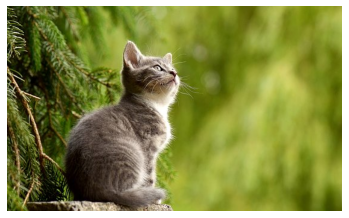

In [ ]:
# Load the image
image = plt.imread("cat.jpg")

# Convert the numpy array to a PIL image
image = Image.fromarray(np.uint8(image))

# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image = transform(image).unsqueeze(0)

# Make a prediction using the first model
output = model_1(image)
probabilities = F.softmax(output, dim=1)
probability, predicted = torch.max(probabilities, 1)

# Convert the class number to a class label
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_label = class_labels[predicted.item()]

# Print the result
print("Model 1: The image is predicted to be a {} with {:.2f}% confidence".format(predicted_label, probability.item() * 100))

# Make a prediction using the second model
output = model_2(image)
probabilities = F.softmax(output, dim=1)
probability, predicted = torch.max(probabilities, 1)

# Convert the class number to a class label
predicted_label = class_labels[predicted.item()]

# Print the result
print("Model 2: The image is predicted to be a {} with {:.2f}% confidence".format(predicted_label, probability.item() * 100))


# Make a prediction using the third model
output = model_3(image)
probabilities = F.softmax(output, dim=1)
probability, predicted = torch.max(probabilities, 1)

# Convert the class number to a class label
predicted_label = class_labels[predicted.item()]

# Print the result
print("Model 3: The image is predicted to be a {} with {:.2f}% confidence".format(predicted_label, probability.item() * 100))



# Make a prediction using the fourth model
output = model_4(image)
probabilities = F.softmax(output, dim=1)
probability, predicted = torch.max(probabilities, 1)

# Convert the class number to a class label
predicted_label = class_labels[predicted.item()]

# Print the result
print("Model 4: The image is predicted to be a {} with {:.2f}% confidence".format(predicted_label, probability.item() * 100))


# Make a prediction using the Fifth model
output = model_5(image)
probabilities = F.softmax(output, dim=1)
probability, predicted = torch.max(probabilities, 1)

# Convert the class number to a class label
predicted_label = class_labels[predicted.item()]



# Print the result
print("Model 5: The image is predicted to be a {} with {:.2f}% confidence".format(predicted_label, probability.item() * 100))


# Plot the original image
plt.imshow(np.array(Image.open("cat.jpg"))/255)
plt.axis("off")
plt.show()
